## Binary semantic segmentation example using U-Net
Preparation of dataset and model training code from here:

https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [1]:
import os
import torch
import torchvision
from tqdm import tqdm

print(torch.__version__)
print(torchvision.__version__)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

/home/shymon/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.1
0.14.1
cuda


See GPU information:

In order to use a GPU with your notebook, select the Runtime > Change runtime type menu, and then set the hardware accelerator dropdown to GPU.


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Mar 18 15:29:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 35%   35C    P0    38W / 220W |   2305MiB /  8192MiB |     37%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### CONFIGURE YOUR PATHS AND HYPERPARAMETERS FOR TRAINING BELOW.

In [3]:
# CONFIGURE PATHS

GD_PATH = "/home/shymon/Documents/phd/03_CODE/mapAI-UNet-torch-v2-regularization/models/"

# TRAIN
TRAIN_IMG_DIR = "/home/shymon/datasets/mapai/train/images/"
TRAIN_MASK_DIR = "/home/shymon/datasets/mapai/train/masks/"

# VAL
VAL_IMG_DIR = "/home/shymon/datasets/mapai/validation/images/"
VAL_MASK_DIR = "/home/shymon/datasets/mapai/validation/masks/"

# TEST
TEST_IMG_DIR = "/home/shymon/Documents/phd/03_CODE/mapAI-UNet-torch-v2-regularization/test/"

# CONFIGURE MapAI DATASET
NUM_CHANNELS = 3
NUM_LEVELS  = 3
NUM_CLASSES = 1

init_lr = 1e-2 # learning rate
EPOCHS = 5 # epochs to train
BATCH_SIZE = 1

# IMAGE SHAPE
IMG_WIDTH = 500
IMG_HEIGHT = 500

THRESHOLD  = 0.5
base_output = "out"

# OUTPUT PATHS
MODEL_PATH = os.path.join(GD_PATH, "geoseg-5-epochs.pth") # change depending on the number of epochs
print(MODEL_PATH)
PLOT_PATH  = os.path.join(GD_PATH, "training_plot-10-epochs.png") # plot for training/val loss
print(PLOT_PATH)
TEST_PATHS = os.path.join(GD_PATH, "test_paths.txt") # file to store the paths for test images
print(TEST_PATHS)

/home/shymon/Documents/phd/03_CODE/mapAI-UNet-torch-v2-regularization/models/geoseg-5-epochs.pth
/home/shymon/Documents/phd/03_CODE/mapAI-UNet-torch-v2-regularization/models/training_plot-10-epochs.png
/home/shymon/Documents/phd/03_CODE/mapAI-UNet-torch-v2-regularization/models/test_paths.txt


### Load and read the MapAI dataset

In [4]:
from torch.utils.data import Dataset
import cv2

class mapAIdataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
		
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
	
		# return a tuple of the image and its mask
		return (image, mask)

### Build GeoSeg architecture

Source: https://github.com/WangLibo1995/GeoSeg/blob/main/geoseg/models/DCSwin.py

!pip install timm

Import the model as a moudle from the appropriate folder.

In [10]:
import DCSwin_model

### Training the segmentation model
Below we append the paths for TRAIN/VAL/TEST sets - images/masks.

In [11]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from imutils import paths
import time

# TRAINING
TrainImagePaths = sorted(list(paths.list_images(TRAIN_IMG_DIR)))
TrainMaskPaths = sorted(list(paths.list_images(TRAIN_MASK_DIR)))

print('TRAINING: ')
print(TrainImagePaths, TrainMaskPaths)

# VALIDATION
ValImagePaths = sorted(list(paths.list_images(VAL_IMG_DIR)))
ValMaskPaths = sorted(list(paths.list_images(VAL_MASK_DIR)))

print('VALIDATION:')
print(ValImagePaths, ValMaskPaths)

# TEST
TestImagePaths = sorted(list(paths.list_images(TEST_IMG_DIR)))

print('TEST:')
print(TestImagePaths)

# Unpack the data
(train_images, train_masks) = (TrainImagePaths, TrainMaskPaths)

(val_images, val_masks) = (ValImagePaths, ValMaskPaths)

test_images = TestImagePaths

# Write the testing images to disk so that we can use them later
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(test_images))
f.close()

TRAINING: 
['/home/shymon/datasets/mapai/train/images/6051_689_0.tif', '/home/shymon/datasets/mapai/train/images/6051_689_1.tif', '/home/shymon/datasets/mapai/train/images/6051_689_10.tif', '/home/shymon/datasets/mapai/train/images/6051_689_11.tif', '/home/shymon/datasets/mapai/train/images/6051_689_12.tif', '/home/shymon/datasets/mapai/train/images/6051_689_13.tif', '/home/shymon/datasets/mapai/train/images/6051_689_14.tif', '/home/shymon/datasets/mapai/train/images/6051_689_15.tif', '/home/shymon/datasets/mapai/train/images/6051_689_16.tif', '/home/shymon/datasets/mapai/train/images/6051_689_17.tif', '/home/shymon/datasets/mapai/train/images/6051_689_18.tif', '/home/shymon/datasets/mapai/train/images/6051_689_19.tif', '/home/shymon/datasets/mapai/train/images/6051_689_2.tif', '/home/shymon/datasets/mapai/train/images/6051_689_20.tif', '/home/shymon/datasets/mapai/train/images/6051_689_21.tif', '/home/shymon/datasets/mapai/train/images/6051_689_22.tif', '/home/shymon/datasets/mapai/tr

Just check if everything is correct.

### Define transformations

I tried out different data augmentation techniques, including Horizontal Flip, Vertical Flip, Contrast, Brightness. They did not improve my results much, the validation and training loss were actually worse than without data augmentation techniques.

https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py


In [12]:
# define transformations
import torchvision.transforms as T

transforms = T.Compose([T.ToPILImage(),
                        T.Resize((IMG_HEIGHT,IMG_WIDTH)),
                        T.ToTensor()])

# create the train and test datasets
trainDS = mapAIdataset(imagePaths=train_images,
                       maskPaths=train_masks,
                       transforms=transforms)

valDS = mapAIdataset(imagePaths=val_images,
                     maskPaths=val_masks,
                     transforms=transforms)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(valDS)} examples in the validation set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS,
                         shuffle=True,
                         batch_size=BATCH_SIZE,
                         pin_memory=PIN_MEMORY,
                         num_workers=os.cpu_count()
                         )

valLoader = DataLoader(valDS,
                       shuffle=False,
                       batch_size=BATCH_SIZE,
                       pin_memory=PIN_MEMORY,
                       num_workers=os.cpu_count()
                       )

[INFO] found 7000 examples in the training set...
[INFO] found 1500 examples in the validation set...


### Initialize model for training

Here we initialize the defined UNET model for training and calculate the steps per epoch for train/val/test set.

In [14]:
model = DCSwin_model.DCSwin().to(DEVICE)

# loss / optimizer
lossFunction = BCEWithLogitsLoss()
opt = Adam(model.parameters(), lr=init_lr)

# calculate steps per epoch for train/val/test
trainSteps = len(trainDS) // BATCH_SIZE 
valSteps = len(valDS) // BATCH_SIZE

print(trainSteps, valSteps)

# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": []}
H

/home/shymon/anaconda3/envs/torch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


7000 1500


{'train_loss': [], 'val_loss': []}

In [15]:
torch.cuda.empty_cache() # PyTorch thing to empty cache

### TRAINING THE MODEL

Run this piece of code only if you want to train the model from scratch.

TO DO:

*   Calculate Intersection over Union
*   Calculate Accuracy metrics

I do not know exactly how to add these metrics into the training process when perfoming validation. Needs some more work.

Training locally: BATCH_SIZE  = 2 takes 5035 MB of GPU memory.



In [16]:
# loop over epochs
print("[INFO] training MODEL ...")
startTime = time.time()

for epoch in tqdm(range(EPOCHS)):
    model.train()

    # initialize total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0

    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send output to device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))

        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFunction(pred, y)

        # kill previously accumulated gradients then
        # perform backpropagation and update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()

        # add the loss to the total training loss
        totalTrainLoss += loss

    # switch of autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()

        # loop over the validation set
        for (x, y) in valLoader:
             # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))

            # make the predictions and calculate the validation loss
            pred = model(x)
            totalValLoss += lossFunction(pred, y)

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
        
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, EPOCHS))
    print("Train loss: {:.6f}, Val loss: {:.4f}".format(avgTrainLoss, avgValLoss))
        
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
    

[INFO] training MODEL ...


  0%|          | 0/5 [00:01<?, ?it/s]


RuntimeError: Given groups=1, weight of size [768, 768, 1, 1], expected input[1, 1024, 16, 16] to have 768 channels, but got 1024 channels instead

In [ ]:
H # show traning/val loss history

#### Training times

*   5 epochs:  1068.83s
*   10 epochs: 1926.91s
*   50 epochs: 9461.90s = 2h 37m 41s  
*   100 epochs: 20829 s  = 5 h 45 m
*   100 epochs - Premium GPU: 2314.83s = 39 min

The mentioned models are stored on my computer and on Google Drive.


#### Check GPU memory

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

### Plot the training and validation loss

In [ ]:
# plot the training loss

print(MODEL_PATH)

# save plot to model folder
PLOT_PATH = GD_PATH

plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(model, MODEL_PATH) # saves the model

As you can see the validation loss is jumping up and down. I do not know why this happens.

### Prediction part

Here the trained model is loaded and use for prediction on test images.

In [ ]:
# Get current working directory
cwd = os.getcwd()
print(cwd)

In [ ]:
# Load saved model for prediction
model = torch.load(GD_PATH + "/unet-10-epochs.pth")
print("model loaded for prediction")

model

#### Download test images for MapAI Dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("sjyhne/mapai_dataset")
dataset

In [ ]:
# Get test datasets

test1, test2 = dataset['task1_test'], dataset['task2_test']

test1[0]['image']

In [ ]:
# If you do not want to move the data use False
import shutil

DATADIR = "home/shymon/datasets"
src = "/home/shymon/.cache/huggingface/datasets/sjyhne___parquet/sjyhne--mapai_dataset-a29285241f23b7c3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec"


# Use True when moving first time
move=True
# Use False when data was already moved
#move=False

# shutil.move(source, destionation)
if move: shutil.move(src, DATADIR)

Run prediction on test images that are stored in a folder, works with both PNG and TIF. If you work with TIF then just change the file ending in the paths.

In [ ]:
print(cwd)

In [ ]:
import random
import gc
from pathlib import Path
import numpy as np
from PIL import Image

# PLOTTING PREDICTIONS AS SINGLE IMAGES

# Output folder for the predictions
output_folder = cwd + "/predictions/"

THRESHOLD = 0.5

# test_image_names
# test_image_names_subset --> ordered paths and names
#test_images --> arrays

# PLOT TEST IMAGES as RGB
for n in range(len(test_images)):
  gc.collect()
  # Test image number
  testImgName = str(Path(test_images[n]).stem) + '.png' # change for tif
  #print('#', testImgName)

   # Make predicton on a test image specified with counter n
  test_img = test_images[n]
  test_img_input = np.expand_dims(test_img, 0)
  #print('#', test_img_input[0])

  # PyTorch --> works
  model.eval()
  with torch.no_grad():
    image = cv2.imread(test_img_input[0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float32") / 255
    
    #print('SIZE: ', image.shape)

    # make the channel axis to be the leading one, add batch dimension
    image = np.transpose(image, (2, 0, 1))
    # create a PyTorch tensor
    image = np.expand_dims(image, 0)
    # flash the tensor to the device
    image  = torch.from_numpy(image).to(DEVICE)

    # make the prediction
    predMask = model(image).squeeze()
    # pass result through sigmoid
    predMask = torch.sigmoid(predMask)

    # convert result to numpy array
    predMask = predMask.cpu().numpy()

    # filter out the weak predictions and convert them to integers
    predMask = (predMask > THRESHOLD) * 255
    predMask = predMask.astype(np.uint8)

    # generate image from array
    pIMG = Image.fromarray(predMask)
    pIMG.save(str(output_folder + testImgName))

    print('Prediction:', testImgName, 'saved to:', output_folder)

### PREDICTION PART WITHOUT REGULARIZATION

Read the predictions from the folder where they were saved and compare the masks with the ground truth.

In [ ]:
import glob

predictions = output_folder
print(predictions)

predictions = glob.glob("/home/shymon/Documents/phd/03_CODE/mapAI-UNet-torch-v2-regularization/predictions/*.tif")
predictions.sort()
predictions

Code to plot the RGB, GT and the predicted image.

In [ ]:
# WRITE A CODE TO SAVE RGB, GROUND TRUTH AND SEGMENTATION HERE
import matplotlib.pyplot as plt

n = 2 # change this number depending on which image you want to test

fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(131)

ax1.set_title('Testing image: ')
image = cv2.imread(test_images[n])[:,:,::-1]
ax1.imshow(image)
ax1.set_axis_off()

ax2 = fig.add_subplot(132)
ax2.set_title('Ground truth: ')
image = cv2.imread(test_masks[n])[:,:,::-1]
ax2.imshow(image)
ax2.set_axis_off()

ax3 = fig.add_subplot(133)
ax3.set_title('Prediction: ')
image = cv2.imread(predictions[n])[:,:,::-1]
ax3.imshow(image)
ax3.set_axis_off()

### BUILDING FOOTPRINT REGULARIZATION

Used repo: https://github.com/zorzi-s/projectRegularization

git clone the repo to the folder where your notebook is stored.

The Python files for projectRegularization need to be saved in Colab.

The pretrained weights need to be downloaded from the provided link:

https://drive.google.com/drive/folders/1IPrDpvFq9ODW7UtPAJR_T-gGzxDat_uu

In [ ]:
# pretrained weights are saved in
ptw = "/content/drive/MyDrive/pretrained_weights/"

In [ ]:
# Go to variables.py --> and modify the file, provide the paths. See the example in this cell.
# if you modify only below, it will not work.

# CONFIGURE THE PATHS IN: variables.py NOT HERE!

# TRAINING
DATASET_RGB = TRAIN_IMG_DIR
DATASET_GTI = TRAIN_MASK_DIR
DATASET_SEG = output_folder

DEBUG_DIR = "/content/drive/MyDrive/debug/"

# INFERENCE
INF_RGB = "/tmp/mapai_small/test/images/*.png" # test RGB images
INF_SEG = "/content/drive/MyDrive/p100e/*.png" # test predictions
INF_OUT = "/content/drive/MyDrive/p100e_reg/" # folder to store regularizations

# PATHS TO THE GAN PRETRAINED WEIGHTS DOWNLOADED FROM GOOGLE DRIVE
MODEL_ENCODER = "/content/drive/MyDrive/pretrained_weights/E140000_e1"
MODEL_GENERATOR = "/content/drive/MyDrive/pretrained_weights/E140000_net"


In [ ]:
# Run the prediction issuing the command

# IF WORKING WITH TIF install imagecodecs
#!pip install imagecodecs  # only for TIF

# RUN REGULARIZATION
!python /content/drive/MyDrive/ColabNotebooks/regularize.py

In [ ]:
# Read Regularizations to plot and compare results

import glob
regularizations = glob.glob("/content/drive/MyDrive/p100e-regularized/*.png")
regularizations.sort()
regularizations

In [ ]:
print(len(test_images))

### COMPARING THE FINAL RESULTS

Code to plot RGB, GT, PREDICTION and REGULARIZATION in a single plot for comparison.

In [ ]:
### PLOT RGB, GT, PREDICTION and REGULARIZATION TOGETHER

# change plot to be used in a for loop

n = 1

fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(141)

ax1.set_title('Testing image: ')
image = cv2.imread(test_images[n])[:,:,::-1]
ax1.imshow(image)
ax1.set_axis_off()

ax2 = fig.add_subplot(142)
ax2.set_title('Ground truth: ')
image = cv2.imread(test_masks[n])[:,:,::-1]
ax2.imshow(image)
ax2.set_axis_off()

ax3 = fig.add_subplot(143)
ax3.set_title('Prediction: ')
image = cv2.imread(predictions[n])[:,:,::-1]
ax3.imshow(image)
ax3.set_axis_off()

ax4 = fig.add_subplot(144)
ax4.set_title('Regularization: ')
image = cv2.imread(regularizations[n])[:,:,::-1]
ax4.imshow(image)
ax4.set_axis_off()

fig.savefig("/content/drive/MyDrive/RESULTS_REGULARIZATION/compare1.png")

### VECTORIZING THE REGULARIZED BUILDING MASKS with GDAL

GDAL: https://gdal.org/'

GDAL: https://www.youtube.com/watch?v=q3DLdMj5zLA

I do not know if it is possible to install GDAL on WINDOWS inside a conda environment.

On Ubuntu you have to follow these steps:



Specific process for installation: https://stackoverflow.com/questions/44005694/no-module-named-gdal

- sudo apt-get update && sudo apt upgrade -y && sudo apt autoremove 
- sudo apt-get install -y cdo nco gdal-bin libgdal-dev-
- python -m pip install --upgrade pip setuptools wheel
- python -m pip install --upgrade gdal
- conda install -c conda forge libgdal
- conda install -c conda-forge libgdal
- conda install -c conda-forge gdal
- conda install tiledb=2.2
- conda install poppler

When you have this you can hopefully vectorize the detected masks quite easily.

In [ ]:
import osgeo
from osgeo import gdal
from osgeo import ogr
print('GDAL version: ', osgeo.gdal.__version__)

# in
input = "/content/drive/MyDrive/p100e_reg/6078_638_24.png"

# out
output = "/content/drive/MyDrive/p100e_reg/6078_638_24.shp" # vector file ready to be used in QGIS / ArcGIS Pro

# Open image with GDAl driver
ds = gdal.Open(input)
# Get the band
band = ds.GetRasterBand(1)

# Create the output shapefile
driver = ogr.GetDriverByName("ESRI Shapefile")
out_ds = driver.CreateDataSource(output)
out_layer = out_ds.CreateLayer(output, geom_type=ogr.wkbPolygon)

# Add a field to the layer to store the pixel values
field_defn = ogr.FieldDefn("Pix_Value", ogr.OFTInteger)
out_layer.CreateField(field_defn)

# Polygonize the PNG file
gdal.Polygonize(band, None, out_layer, 0, [], callback=None)

# Close the input and output files
out_ds = None
ds = None

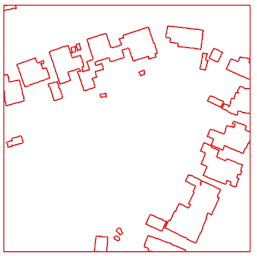

For the builing detection case we need to only keep the vectors with pixel value 255. Easiest solution is to use: Extract by attribute. The Python solution with GDAL can be found below.

In [ ]:
# ogr2ogr -where ID="1" outfile.shp infile.shp

# RUN from the command line inside Ubuntu
!ogr2ogr -where Pix_Value="255" 6078_638_24b.shp 6078_638_24.shp

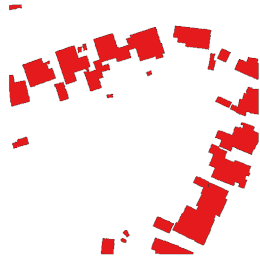

### GEOREFERENCING THE VECTORIZED MASKS

This is the last step for the practical applications of our methodology. I would need to obtain the geolocation files for the mapAI dataset, so I can georeference each mask from the test set.